# V1 of the retrieval algorithm - using a weighted combination of embeddings and metadata


In [1]:
import os 
import sys 
import networkx as nx
import matplotlib as mpl
import pprint
import pstats
import pandas as pd
import numpy as np
import tqdm
from sentence_transformers import SentenceTransformer

from typing import List, Tuple
from llama_index.core.schema import Document

# Add the project root directory to the system path
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)

from src.etl_module import etl_functions, embedding_functions
from src.processing_module import v0_retrieval, v1_retrieval, distance_metrics
from src.evaluation_module import output_functions, graph_scoring_functions

from src.processing_module.distance_metrics import calculate_distance_parallel

/Users/lukasalemu/Downloads/ls/envs/dissertation_rag/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load the document index
document_index = etl_functions.load_documents()

# Embed the document index
embedded_index = embedding_functions.embed_index(document_index)

Embedding Documents: 100%|██████████| 197/197 [00:04<00:00, 44.48it/s]


In [3]:
test_res2 = v0_retrieval.retrieve_top_k(
    np.array(embedded_index[0].embedding),
    embedded_index,
    5
)

In [4]:
test_res2

[('6f275523-ba7a-43c7-b2cb-d03612d93617', array([[1.]])),
 ('b3ec18cf-fe01-4c2b-92a1-9fee4166058e', array([[0.92786948]])),
 ('65a99123-5ffc-4f72-a50f-4d521b3e6a8f', array([[0.71063419]])),
 ('c9348aff-073e-4f17-a8d6-65616918a9d2', array([[0.66860328]])),
 ('d31ce150-ac6c-4b41-9015-82fa61ceb24c', array([[0.65944216]]))]

In [5]:
test_res = v1_retrieval.retrieve_top_k(
    embedded_index[0], 
    embedded_index,
    5
)

In [6]:
test_res

[('6f275523-ba7a-43c7-b2cb-d03612d93617', 1.0),
 ('65a99123-5ffc-4f72-a50f-4d521b3e6a8f', 0.9737272727272728),
 ('d31ce150-ac6c-4b41-9015-82fa61ceb24c', 0.9689999999999999),
 ('984dec43-911b-4b7c-8ebc-89a86caa8a34', 0.9679090909090909),
 ('a3ffb4b9-0561-46b3-8819-bfe4ccced0a9', 0.9661818181818181)]

### Performance optimisation - 7 seconds per doc will take a long time to run on the entire dataset


In [7]:
%prun -r -D ../data/03_output/v1_output.prof v1_retrieval.retrieve_top_k(embedded_index[0], embedded_index,5)

 
*** Profile stats marshalled to file '../data/03_output/v1_output.prof'.


         7476158 function calls (6937736 primitive calls) in 7.995 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       10    1.189    0.119    1.189    0.119 {method 'read' of '_ssl._SSLSocket' objects}
    29156    0.880    0.000    0.880    0.000 {built-in method torch._C._nn.linear}
    10244    0.869    0.000    0.869    0.000 {built-in method torch.layer_norm}
    86785    0.822    0.000    0.822    0.000 {method 'to' of 'torch._C.TensorBase' objects}
      788    0.425    0.001    0.425    0.001 {method 'cpu' of 'torch._C.TensorBase' objects}
     4728    0.318    0.000    1.331    0.000 modeling_bert.py:276(forward)
     9456    0.301    0.000    0.301    0.000 {built-in method torch.matmul}
97836/789    0.166    0.000    0.566    0.001 module.py:799(_apply)
     4728    0.157    0.000    0.157    0.000 {method 'softmax' of 'torch._C.TensorBase' objects}
     4728    0.153    0.000    0.744    0.000 modeling_bert.

In [8]:
p = pstats.Stats('../data/03_output/v1_output.prof')
# p.sort_stats('cumulative').print_stats()
p.sort_stats('cumulative').print_stats(100)

Sun Apr 21 22:05:17 2024    ../data/03_output/v1_output.prof

         7476158 function calls (6937736 primitive calls) in 7.995 seconds

   Ordered by: cumulative time
   List reduced from 1370 to 100 due to restriction <100>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    7.995    7.995 {built-in method builtins.exec}
        1    0.003    0.003    7.995    7.995 <string>:1(<module>)
        1    0.001    0.001    7.993    7.993 /Users/lukasalemu/Documents/00. Bank of England/00. Degree/Dissertation/structured-rag/src/processing_module/v1_retrieval.py:12(retrieve_top_k)
      197    0.002    0.000    6.610    0.034 /Users/lukasalemu/Documents/00. Bank of England/00. Degree/Dissertation/structured-rag/src/processing_module/distance_metrics.py:383(calculate_distance_vector)
      788    0.016    0.000    6.094    0.008 /Users/lukasalemu/Downloads/ls/envs/dissertation_rag/lib/python3.10/site-packages/sentence_transformers/SentenceT

## As opposed to doing the graph construction doc by doc, we can calculate all the similarities once in a big matrix and then fill in the graph from that

1. Retrieve top K looks across all the index, compares all the documents, and returns the top 5 documents
2. Say there are 100 documents, this runs 100 times, looking across 100 documents each. This is 10,000 comparisons.
3. This takes 7 seconds per doc right now, but that will increase with the number of docs that we have to compare, to return the top 5.

Can we optimise this?

What if for each document, we compare the remaining documents similarity and store it in a big matrix?

1. The first document will be compared with 100 others, the second 99, the third 98, etc.
2. This will result in 100 + 99 + 98 + ... + 1 = 5050 comparisons
3. This will be done once, and then we can use this matrix to retrieve the top 5 documents for each document in the index
4. This quickens the process by a factor of 2

In [34]:
embed_model = SentenceTransformer("all-MiniLM-L6-v2")

doc_distance_vectors = {}

# For each document
for doc in tqdm.tqdm(embedded_index):
    
    # Calculate all the distance vectors for every other doc and nest them into a dictionar
    doc_distance_vectors[doc.id_] = {
        other_doc.id_: distance_metrics.calculate_distance_vector(doc, other_doc, embed_model) for other_doc in embedded_index
    }

100%|██████████| 197/197 [17:40<00:00,  5.38s/it]


In [38]:
# Persist the distance vectors with pickle

import pickle

with open("../data/03_output/v1_algo_doc_distance_vectors.pkl", "wb") as f:
    pickle.dump(doc_distance_vectors, f)

# Further Performance optimisation
17 mins for two documents is way too slow...

See multiprocessed graph for the performance optimisations

In [19]:
import pickle
with open("../data/03_output/adjacency_dict.pkl", "rb") as f:
    adj_dict = pickle.load(f)
    
# Iterate over the adjacency dict to remove every edge which links a node to the same node
for node0, edge_dict in adj_dict.items():
    for node1, weight in list(edge_dict.items()):
        if node0 == node1:
            del edge_dict[node1]
            
        if weight['weight'] < 0.5:
            del edge_dict[node1]

In [20]:
len(adj_dict)

178

In [21]:
v1_graph = nx.from_dict_of_dicts(adj_dict)

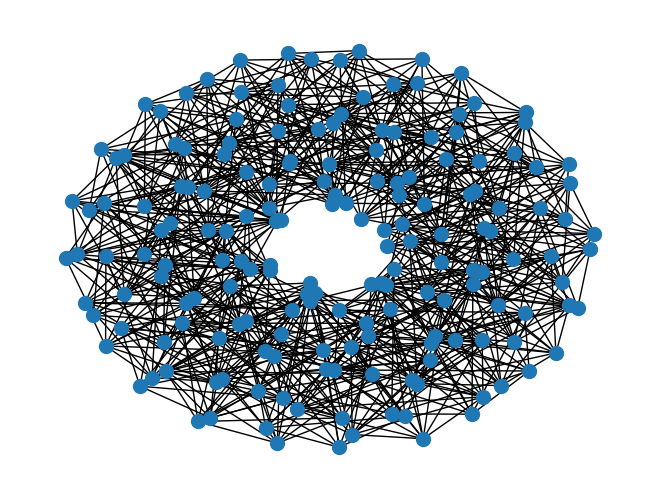

In [22]:
pos = nx.kamada_kawai_layout(v1_graph)
nx.draw(v1_graph, pos, node_size=100)

In [24]:
pprint.pprint(adj_dict)

{'01c24eac-c1e7-4fa2-a06b-b12653da8022': {'084b7bab-8326-4fd1-8113-fff66cb41f5d': {'weight': 0.9664545454545455},
                                          '351d585a-fdf4-4433-991b-20e13a6c170c': {'weight': 0.9619090909090908},
                                          '7652db7d-2436-4279-9a5a-dc760f6f5eac': {'weight': 0.9647272727272728},
                                          '8412936f-6c01-4ce6-8063-9d0a01c11a59': {'weight': 0.9600000000000001},
                                          '8ce05221-860d-4f0e-85f8-4a3d0bb0e548': {'weight': 0.9614545454545455},
                                          'a1f07275-1dae-4852-9aa6-e464507ee976': {'weight': 0.9481818181818181},
                                          'bdb0d0d7-ae4a-4b46-a5a4-009fce777271': {'weight': 0.9546363636363636},
                                          'fd6bbf4e-1ec0-4871-9100-7de9bdef9aa0': {'weight': 0.9707272727272728}},
 '05a61727-d478-4767-a661-ef3d47fd0084': {'1e58a37b-558d-426b-85d7-1978796594ff': {'wei